<a href="https://colab.research.google.com/github/sergekamanzi/Fraud-Detection/blob/main/fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


Epoch 1/50
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 155s 35ms/step - accuracy: 0.9233 - loss: 0.0126 - val_accuracy: 0.9626 - val_loss: 0.0016
Epoch 2/50
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 190s 32ms/step - accuracy: 0.9792 - loss: 9.0306e-04 - val_accuracy: 0.9861 - val_loss: 2.6943e-04
Epoch 3/50
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 134s 32ms/step - accuracy: 0.9870 - loss: 4.0247e-04 - val_accuracy: 0.9901 - val_loss: 1.5657e-04
Epoch 4/50
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 146s 33ms/step - accuracy: 0.9900 - loss: 2.6491e-04 - val_accuracy: 0.9864 - val_loss: 3.3137e-04
Epoch 5/50
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 135s 32ms/step - accuracy: 0.9918 - loss: 1.9275e-04 - val_accuracy: 0.9879 - val_loss: 2.4765e-04
Epoch 6/50
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 142s 32ms/step - accuracy: 0.9924 - loss: 1.7036e-04 - val_accuracy: 0.9913 - val_loss: 1.4243e-04
Epoch 7/50
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 139s 31ms/step - accuracy: 0.9931 - loss: 1.4680e-04 - val_accuracy: 0.9910 - val_loss: 1.3592e-04
Epoch 8/50
4250/4250 

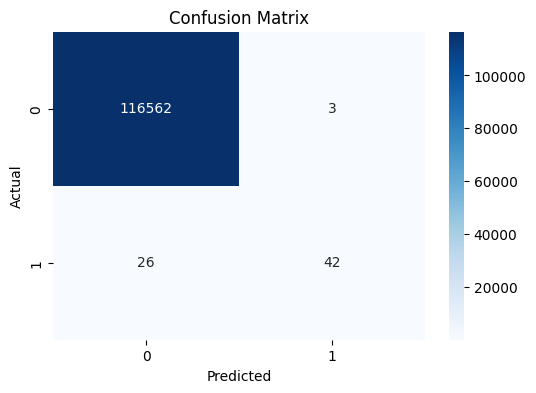

In [3]:
# Install Required Dependencies
!pip install tensorflow-addons keras --upgrade

# Import Required Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

# Load Dataset
data = pd.read_csv('/content/fraud detection.csv')

# Encode categorical variables
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])

# Feature Engineering
data['balance_change_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_change_dest'] = data['oldbalanceDest'] - data['newbalanceDest']
data['transaction_ratio_orig'] = data['amount'] / (data['oldbalanceOrg'] + 1)
data['transaction_ratio_dest'] = data['amount'] / (data['oldbalanceDest'] + 1)

# Handle missing values
data.fillna(data.median(), inplace=True)

# Drop unnecessary columns
data.drop(columns=['nameDest','isFlaggedFraud'], inplace=True)

# Split features and target
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE to handle class imbalance (Increase Fraud Cases to 100%)
smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Balance fraud and non-fraud
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Compute Class Weights (Aggressive Fraud Weight)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 3}  # More emphasis on fraud cases

# Custom Focal Loss Function (Fixes TensorFlow Addons Issue)
def focal_loss(alpha=0.75, gamma=3):
    def loss(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = alpha * K.pow((1 - p_t), gamma)
        return focal_term * bce
    return loss

# Define the Advanced Neural Network Model (Deeper + Residual Connections)
inputs = Input(shape=(X_train_resampled.shape[1],))

# First Dense Layer (512 Neurons)
x = Dense(512, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Residual Branch (Ensure Same Shape)
residual = Dense(512, activation='relu')(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

# Add Residual Connection (Now Same Shape)
x = Add()([x, residual])

# More Layers After Residual Connection
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output Layer
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)


# Compile Model with Adam and Custom Focal Loss
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss=focal_loss(alpha=0.75, gamma=3), metrics=['accuracy'])

# Train the Model
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=50, batch_size=256,
                    class_weight=class_weights_dict,
                    verbose=1)

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Adjust Classification Threshold Using Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_pred_probs)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]  # F1-score optimization

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > best_threshold).astype("int32")

# Calculate Accuracy and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()